# VGG16 Furniture Classification Experiments

This notebook trains VGG16 on furniture profitability classification with three data configurations:
- **all**: All data in dataset
- **high_quality**: High confidence predictions (≥0.8 confidence score for any tabular column)
- **brand_msrp_only**: Only listings with known brand and MSRP data

In [3]:
# Login to HuggingFace to access private dataset
from huggingface_hub import login

login()

In [ ]:
import sys
sys.path.append('..')

import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import models, transforms
import numpy as np
import pandas as pd
from pathlib import Path

from experiments.dataset_utils_hf import load_and_split_hf_data, get_hf_data_loaders, DATASET_REPO
from experiments.training_utils import (
    train_model, evaluate_model, plot_training_history, 
    plot_confusion_matrix, visualize_misclassified,
    save_experiment_results, print_experiment_summary
)

# Set random seeds for reproducability across experiments
torch.manual_seed(42)
np.random.seed(42)

# Device config
if torch.cuda.is_available():
    DEVICE = torch.device('cuda')
    print(f"Using device: CUDA - {torch.cuda.get_device_name(0)}")
else:
    DEVICE = torch.device('cpu')
    print(f"Using device: CPU")

# Paths
RESULTS_DIR = Path('results/vgg16')
MODELS_DIR = Path('models/vgg16')
RESULTS_DIR.mkdir(parents=True, exist_ok=True)
MODELS_DIR.mkdir(parents=True, exist_ok=True)

print(f"Using HuggingFace dataset: {DATASET_REPO}")

Using device: CUDA - Tesla V100-SXM2-16GB

✓ Using HuggingFace dataset: adybacki/furniture-profitability-dataset
  Images will be cached automatically for 10-20x speedup!


## Data Transforms

In [ ]:
# VGG16 expects 224x224 images with ImageNet normalization
IMAGE_SIZE = 224
IMAGE_MEAN = [0.485, 0.456, 0.406]
IMAGE_STD = [0.229, 0.224, 0.225]

# Data augmentatino and normalization for training
transform = transforms.Compose([
    transforms.Resize((IMAGE_SIZE, IMAGE_SIZE)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(degrees=15),
    transforms.ToTensor(),
    transforms.Normalize(mean=IMAGE_MEAN, std=IMAGE_STD)
])

## Model Definition

In [ ]:
def create_vgg16_model():
    """
    Create VGG16 model for binary classification (buy or not)
    """
    # Load pre-trained VGG16
    model = models.vgg16(pretrained=True)
    
    # Freeze feature extraction layers
    for param in model.features.parameters():
        param.requires_grad = False

    # VGG16 features output is 25088 (512 * 7 * 7)
    model.classifier = nn.Sequential(
        nn.Flatten(),
        nn.Dropout(0.5),
        nn.Linear(25088, 256),
        nn.ReLU(),
        nn.Dropout(0.5),
        nn.Linear(256, 2)
    )
    
    return model

## Training Configuration

In [ ]:
# Hyperparameters
BATCH_SIZE = 32
NUM_EPOCHS = 15
LEARNING_RATE = 0.0001

# Data modes to test
DATA_MODES = ['all', 'high_quality', 'brand_msrp_only']

## Experiment Loop

Run experiments for all three data configurations


EXPERIMENT: VGG16 with ALL data

Loading dataset from HuggingFace: adybacki/furniture-profitability-dataset


README.md:   0%|          | 0.00/777 [00:00<?, ?B/s]

data/train-00000-of-00003.parquet:   0%|          | 0.00/322M [00:00<?, ?B/s]

data/train-00001-of-00003.parquet:   0%|          | 0.00/352M [00:00<?, ?B/s]

data/train-00002-of-00003.parquet:   0%|          | 0.00/356M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/26554 [00:00<?, ? examples/s]

✓ Loaded 26,554 total samples

Filtering for data_mode: all
✓ 26,554 samples after filtering

Original class distribution: {0: 18078, 1: 8476}
Balancing classes to 8476 samples each...
Balanced class distribution: {0: 8476, 1: 8476}

Train samples: 13561
Validation samples: 1695
Test samples: 1696
Dataset initialized with 13561 samples
Class distribution: {1: 6781, 0: 6780}
Dataset initialized with 1695 samples
Class distribution: {0: 848, 1: 847}
Dataset initialized with 1696 samples
Class distribution: {0: 848, 1: 848}

Training vgg16_all



────────────────────────────────────────────────────────────
✓ EPOCH 1/15 COMPLETE - Time: 98.53s
────────────────────────────────────────────────────────────
Train - Loss: 0.7089 | Acc: 0.5415 | F1: 0.5391
Val   - Loss: 0.6752 | Acc: 0.5858 | F1: 0.6029
🏆 New best model saved (F1: 0.6029)
────────────────────────────────────────────────────────────



────────────────────────────────────────────────────────────
✓ EPOCH 2/15 COMPLETE - Time: 98.57s
────────────────────────────────────────────────────────────
Train - Loss: 0.6701 | Acc: 0.5919 | F1: 0.5945
Val   - Loss: 0.6850 | Acc: 0.5676 | F1: 0.3937
────────────────────────────────────────────────────────────



────────────────────────────────────────────────────────────
✓ EPOCH 3/15 COMPLETE - Time: 98.55s
────────────────────────────────────────────────────────────
Train - Loss: 0.6499 | Acc: 0.6202 | F1: 0.6229
Val   - Loss: 0.6712 | Acc: 0.5929 | F1: 0.5627
────────────────────────────────────────────────────────────



────────────────────────────────────────────────────────────
✓ EPOCH 4/15 COMPLETE - Time: 98.48s
────────────────────────────────────────────────────────────
Train - Loss: 0.6338 | Acc: 0.6331 | F1: 0.6357
Val   - Loss: 0.6890 | Acc: 0.5847 | F1: 0.5021
────────────────────────────────────────────────────────────



────────────────────────────────────────────────────────────
✓ EPOCH 5/15 COMPLETE - Time: 98.86s
────────────────────────────────────────────────────────────
Train - Loss: 0.6131 | Acc: 0.6604 | F1: 0.6647
Val   - Loss: 0.6742 | Acc: 0.5894 | F1: 0.5595
────────────────────────────────────────────────────────────



────────────────────────────────────────────────────────────
✓ EPOCH 6/15 COMPLETE - Time: 98.72s
────────────────────────────────────────────────────────────
Train - Loss: 0.5858 | Acc: 0.6808 | F1: 0.6849
Val   - Loss: 0.6926 | Acc: 0.5841 | F1: 0.5992
────────────────────────────────────────────────────────────



────────────────────────────────────────────────────────────
✓ EPOCH 7/15 COMPLETE - Time: 98.85s
────────────────────────────────────────────────────────────
Train - Loss: 0.5652 | Acc: 0.6996 | F1: 0.7025
Val   - Loss: 0.7184 | Acc: 0.6018 | F1: 0.6096
🏆 New best model saved (F1: 0.6096)
────────────────────────────────────────────────────────────



────────────────────────────────────────────────────────────
✓ EPOCH 8/15 COMPLETE - Time: 99.14s
────────────────────────────────────────────────────────────
Train - Loss: 0.5364 | Acc: 0.7204 | F1: 0.7219
Val   - Loss: 0.7260 | Acc: 0.6035 | F1: 0.5937
────────────────────────────────────────────────────────────



────────────────────────────────────────────────────────────
✓ EPOCH 9/15 COMPLETE - Time: 99.03s
────────────────────────────────────────────────────────────
Train - Loss: 0.5000 | Acc: 0.7460 | F1: 0.7469
Val   - Loss: 0.7578 | Acc: 0.5971 | F1: 0.5975
────────────────────────────────────────────────────────────



────────────────────────────────────────────────────────────
✓ EPOCH 10/15 COMPLETE - Time: 98.91s
────────────────────────────────────────────────────────────
Train - Loss: 0.4756 | Acc: 0.7672 | F1: 0.7688
Val   - Loss: 0.7465 | Acc: 0.5835 | F1: 0.6237
🏆 New best model saved (F1: 0.6237)
────────────────────────────────────────────────────────────



────────────────────────────────────────────────────────────
✓ EPOCH 11/15 COMPLETE - Time: 98.49s
────────────────────────────────────────────────────────────
Train - Loss: 0.4416 | Acc: 0.7858 | F1: 0.7867
Val   - Loss: 0.8482 | Acc: 0.5823 | F1: 0.4685
────────────────────────────────────────────────────────────



────────────────────────────────────────────────────────────
✓ EPOCH 12/15 COMPLETE - Time: 99.21s
────────────────────────────────────────────────────────────
Train - Loss: 0.4050 | Acc: 0.8109 | F1: 0.8119
Val   - Loss: 0.8865 | Acc: 0.5841 | F1: 0.6120
────────────────────────────────────────────────────────────



────────────────────────────────────────────────────────────
✓ EPOCH 13/15 COMPLETE - Time: 98.35s
────────────────────────────────────────────────────────────
Train - Loss: 0.3705 | Acc: 0.8347 | F1: 0.8352
Val   - Loss: 0.9684 | Acc: 0.5711 | F1: 0.5131
────────────────────────────────────────────────────────────



────────────────────────────────────────────────────────────
✓ EPOCH 14/15 COMPLETE - Time: 98.15s
────────────────────────────────────────────────────────────
Train - Loss: 0.3503 | Acc: 0.8444 | F1: 0.8451
Val   - Loss: 0.9487 | Acc: 0.5835 | F1: 0.5463
────────────────────────────────────────────────────────────



────────────────────────────────────────────────────────────
✓ EPOCH 15/15 COMPLETE - Time: 98.33s
────────────────────────────────────────────────────────────
Train - Loss: 0.3218 | Acc: 0.8589 | F1: 0.8594
Val   - Loss: 0.9872 | Acc: 0.5752 | F1: 0.5545
────────────────────────────────────────────────────────────

✓ TRAINING COMPLETE - vgg16_all
Best Validation F1: 0.6237
Total Epochs: 15


EXPERIMENT SUMMARY
Model: VGG16
Data Mode: all

Test Set Performance:
  Accuracy:  0.5890
  F1 Score:  0.6295
  Precision: 0.5731
  Recall:    0.6981



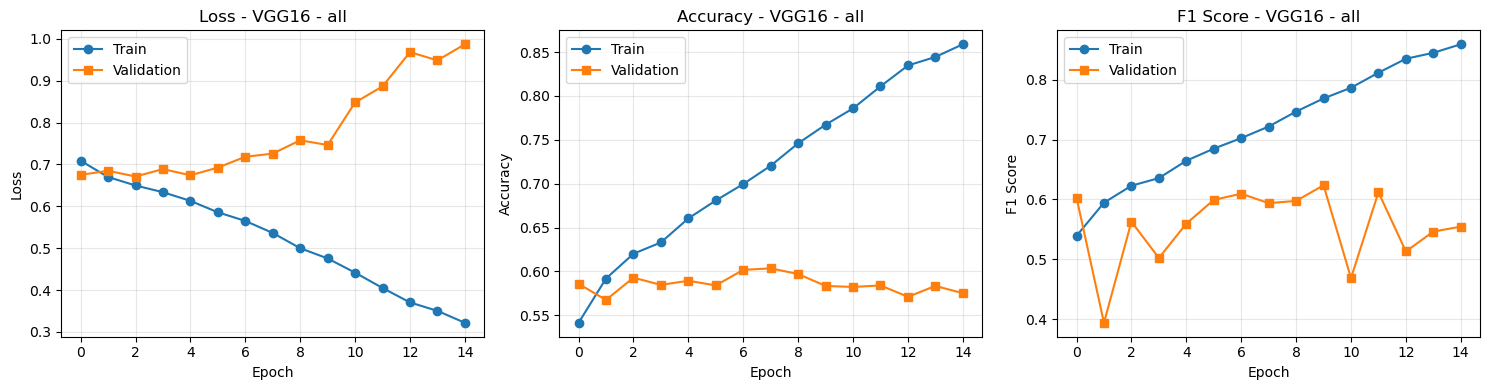

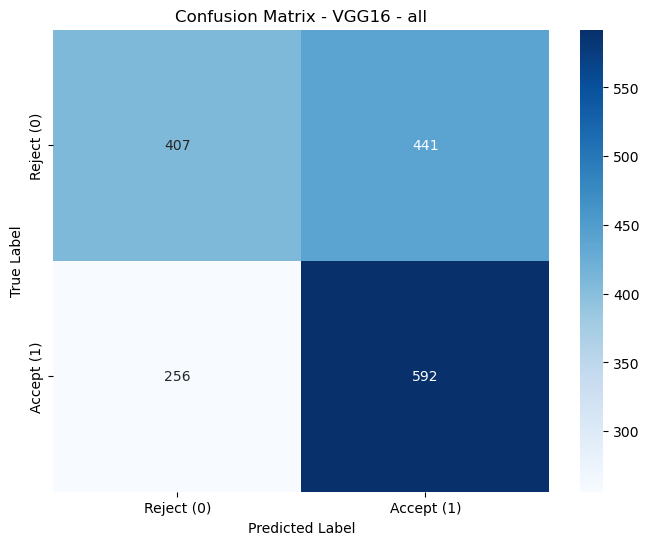


Analyzing misclassified examples...


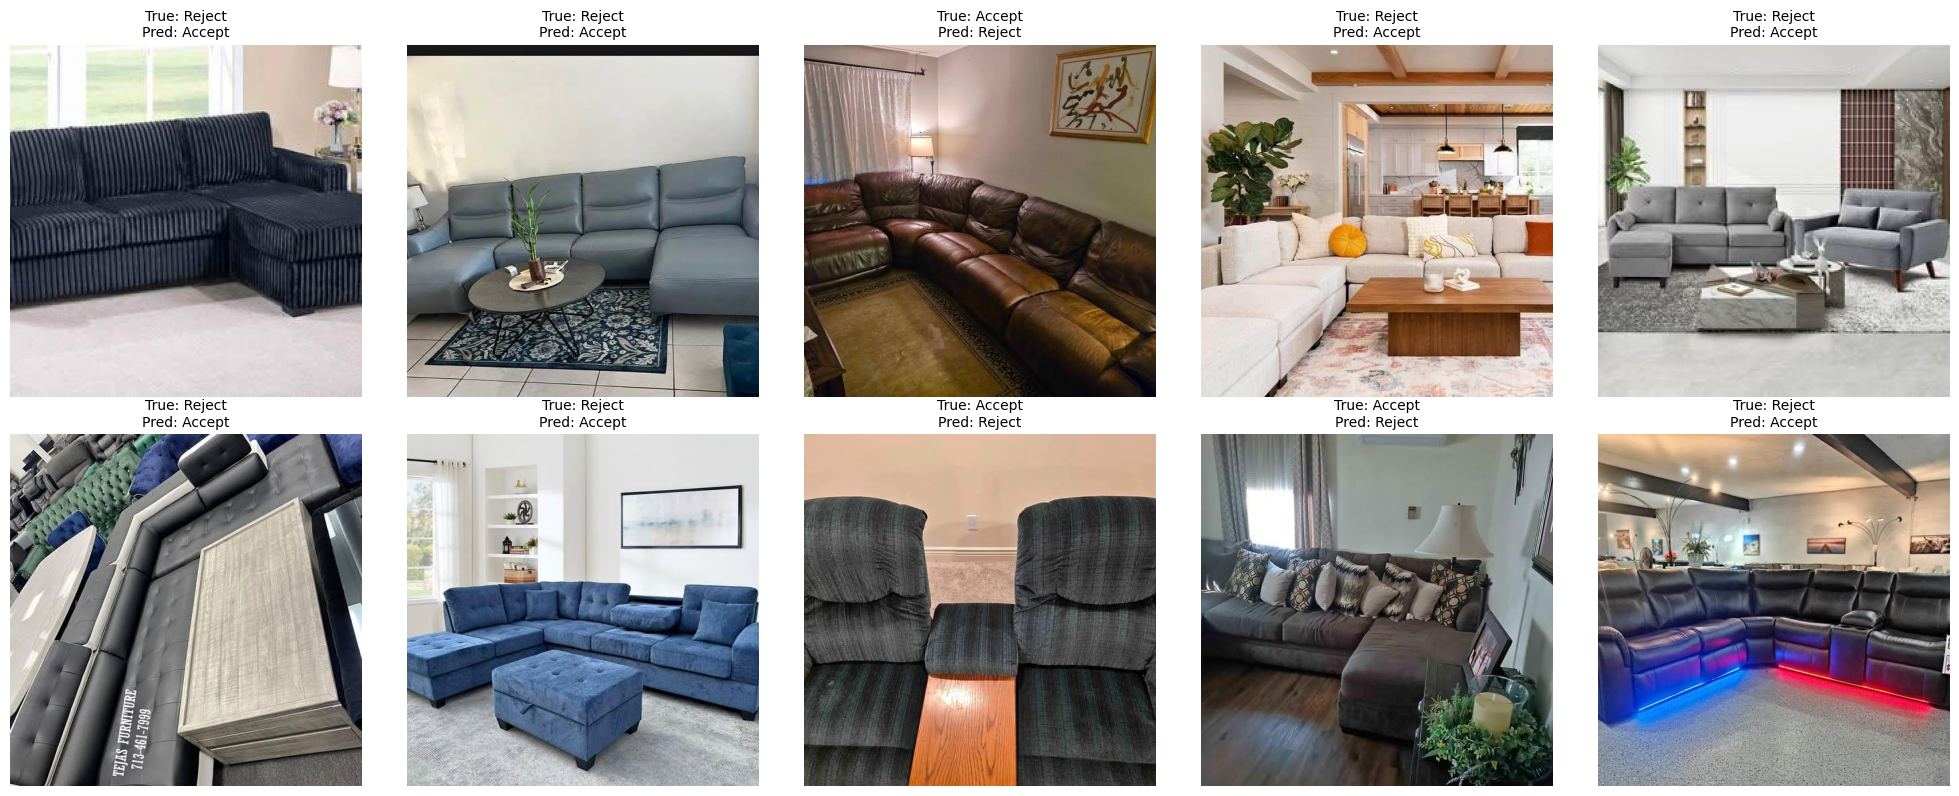

Results saved to results/vgg16/vgg16_all_results.json

EXPERIMENT: VGG16 with HIGH_QUALITY data

Loading dataset from HuggingFace: adybacki/furniture-profitability-dataset
✓ Loaded 26,554 total samples

Filtering for data_mode: high_quality
✓ 12,846 samples after filtering

Original class distribution: {0: 6437, 1: 6409}

Train samples: 10276
Validation samples: 1285
Test samples: 1285
Dataset initialized with 10276 samples
Class distribution: {0: 5149, 1: 5127}
Dataset initialized with 1285 samples
Class distribution: {0: 644, 1: 641}
Dataset initialized with 1285 samples
Class distribution: {0: 644, 1: 641}

Training vgg16_high_quality



────────────────────────────────────────────────────────────
✓ EPOCH 1/15 COMPLETE - Time: 75.02s
────────────────────────────────────────────────────────────
Train - Loss: 0.7087 | Acc: 0.5569 | F1: 0.5575
Val   - Loss: 0.6834 | Acc: 0.5658 | F1: 0.3178
🏆 New best model saved (F1: 0.3178)
────────────────────────────────────────────────────────────



────────────────────────────────────────────────────────────
✓ EPOCH 2/15 COMPLETE - Time: 74.86s
────────────────────────────────────────────────────────────
Train - Loss: 0.6570 | Acc: 0.6120 | F1: 0.6146
Val   - Loss: 0.6613 | Acc: 0.5938 | F1: 0.4811
🏆 New best model saved (F1: 0.4811)
────────────────────────────────────────────────────────────



────────────────────────────────────────────────────────────
✓ EPOCH 3/15 COMPLETE - Time: 75.16s
────────────────────────────────────────────────────────────
Train - Loss: 0.6309 | Acc: 0.6387 | F1: 0.6448
Val   - Loss: 0.6399 | Acc: 0.6304 | F1: 0.5930
🏆 New best model saved (F1: 0.5930)
────────────────────────────────────────────────────────────



────────────────────────────────────────────────────────────
✓ EPOCH 4/15 COMPLETE - Time: 75.15s
────────────────────────────────────────────────────────────
Train - Loss: 0.6045 | Acc: 0.6598 | F1: 0.6678
Val   - Loss: 0.6428 | Acc: 0.6272 | F1: 0.6501
🏆 New best model saved (F1: 0.6501)
────────────────────────────────────────────────────────────



────────────────────────────────────────────────────────────
✓ EPOCH 5/15 COMPLETE - Time: 75.30s
────────────────────────────────────────────────────────────
Train - Loss: 0.5807 | Acc: 0.6883 | F1: 0.6965
Val   - Loss: 0.6674 | Acc: 0.6218 | F1: 0.6155
────────────────────────────────────────────────────────────



────────────────────────────────────────────────────────────
✓ EPOCH 6/15 COMPLETE - Time: 74.84s
────────────────────────────────────────────────────────────
Train - Loss: 0.5572 | Acc: 0.7049 | F1: 0.7141
Val   - Loss: 0.6679 | Acc: 0.6257 | F1: 0.6557
🏆 New best model saved (F1: 0.6557)
────────────────────────────────────────────────────────────



────────────────────────────────────────────────────────────
✓ EPOCH 7/15 COMPLETE - Time: 75.14s
────────────────────────────────────────────────────────────
Train - Loss: 0.5312 | Acc: 0.7270 | F1: 0.7316
Val   - Loss: 0.6949 | Acc: 0.6140 | F1: 0.6125
────────────────────────────────────────────────────────────



────────────────────────────────────────────────────────────
✓ EPOCH 8/15 COMPLETE - Time: 74.92s
────────────────────────────────────────────────────────────
Train - Loss: 0.4956 | Acc: 0.7481 | F1: 0.7524
Val   - Loss: 0.7492 | Acc: 0.6078 | F1: 0.6069
────────────────────────────────────────────────────────────



────────────────────────────────────────────────────────────
✓ EPOCH 9/15 COMPLETE - Time: 75.08s
────────────────────────────────────────────────────────────
Train - Loss: 0.4625 | Acc: 0.7740 | F1: 0.7776
Val   - Loss: 0.7757 | Acc: 0.6296 | F1: 0.6310
────────────────────────────────────────────────────────────



────────────────────────────────────────────────────────────
✓ EPOCH 10/15 COMPLETE - Time: 75.09s
────────────────────────────────────────────────────────────
Train - Loss: 0.4331 | Acc: 0.7948 | F1: 0.7972
Val   - Loss: 0.7768 | Acc: 0.6241 | F1: 0.6562
🏆 New best model saved (F1: 0.6562)
────────────────────────────────────────────────────────────



────────────────────────────────────────────────────────────
✓ EPOCH 11/15 COMPLETE - Time: 74.80s
────────────────────────────────────────────────────────────
Train - Loss: 0.3938 | Acc: 0.8158 | F1: 0.8172
Val   - Loss: 0.9156 | Acc: 0.6140 | F1: 0.5709
────────────────────────────────────────────────────────────



────────────────────────────────────────────────────────────
✓ EPOCH 12/15 COMPLETE - Time: 74.72s
────────────────────────────────────────────────────────────
Train - Loss: 0.3604 | Acc: 0.8354 | F1: 0.8364
Val   - Loss: 0.9133 | Acc: 0.6109 | F1: 0.6542
────────────────────────────────────────────────────────────



────────────────────────────────────────────────────────────
✓ EPOCH 13/15 COMPLETE - Time: 74.83s
────────────────────────────────────────────────────────────
Train - Loss: 0.3319 | Acc: 0.8570 | F1: 0.8578
Val   - Loss: 0.9536 | Acc: 0.6233 | F1: 0.5940
────────────────────────────────────────────────────────────



────────────────────────────────────────────────────────────
✓ EPOCH 14/15 COMPLETE - Time: 74.74s
────────────────────────────────────────────────────────────
Train - Loss: 0.3041 | Acc: 0.8713 | F1: 0.8712
Val   - Loss: 0.9788 | Acc: 0.6054 | F1: 0.5868
────────────────────────────────────────────────────────────



────────────────────────────────────────────────────────────
✓ EPOCH 15/15 COMPLETE - Time: 74.62s
────────────────────────────────────────────────────────────
Train - Loss: 0.2799 | Acc: 0.8795 | F1: 0.8799
Val   - Loss: 1.0026 | Acc: 0.6296 | F1: 0.6350
────────────────────────────────────────────────────────────

✓ TRAINING COMPLETE - vgg16_high_quality
Best Validation F1: 0.6562
Total Epochs: 15


EXPERIMENT SUMMARY
Model: VGG16
Data Mode: high_quality

Test Set Performance:
  Accuracy:  0.6140
  F1 Score:  0.6467
  Precision: 0.5950
  Recall:    0.7083



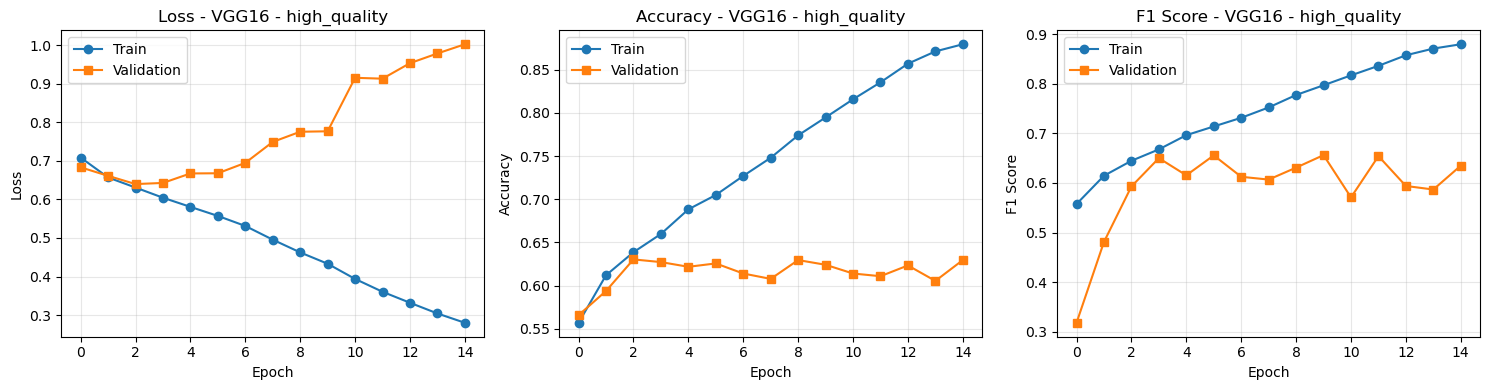

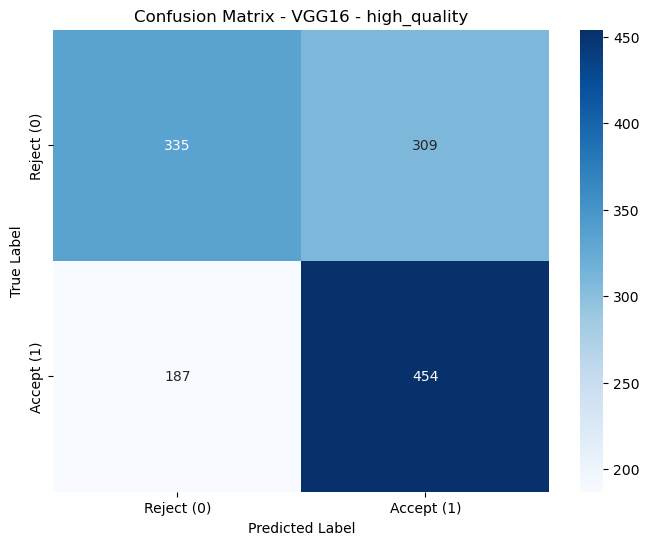


Analyzing misclassified examples...


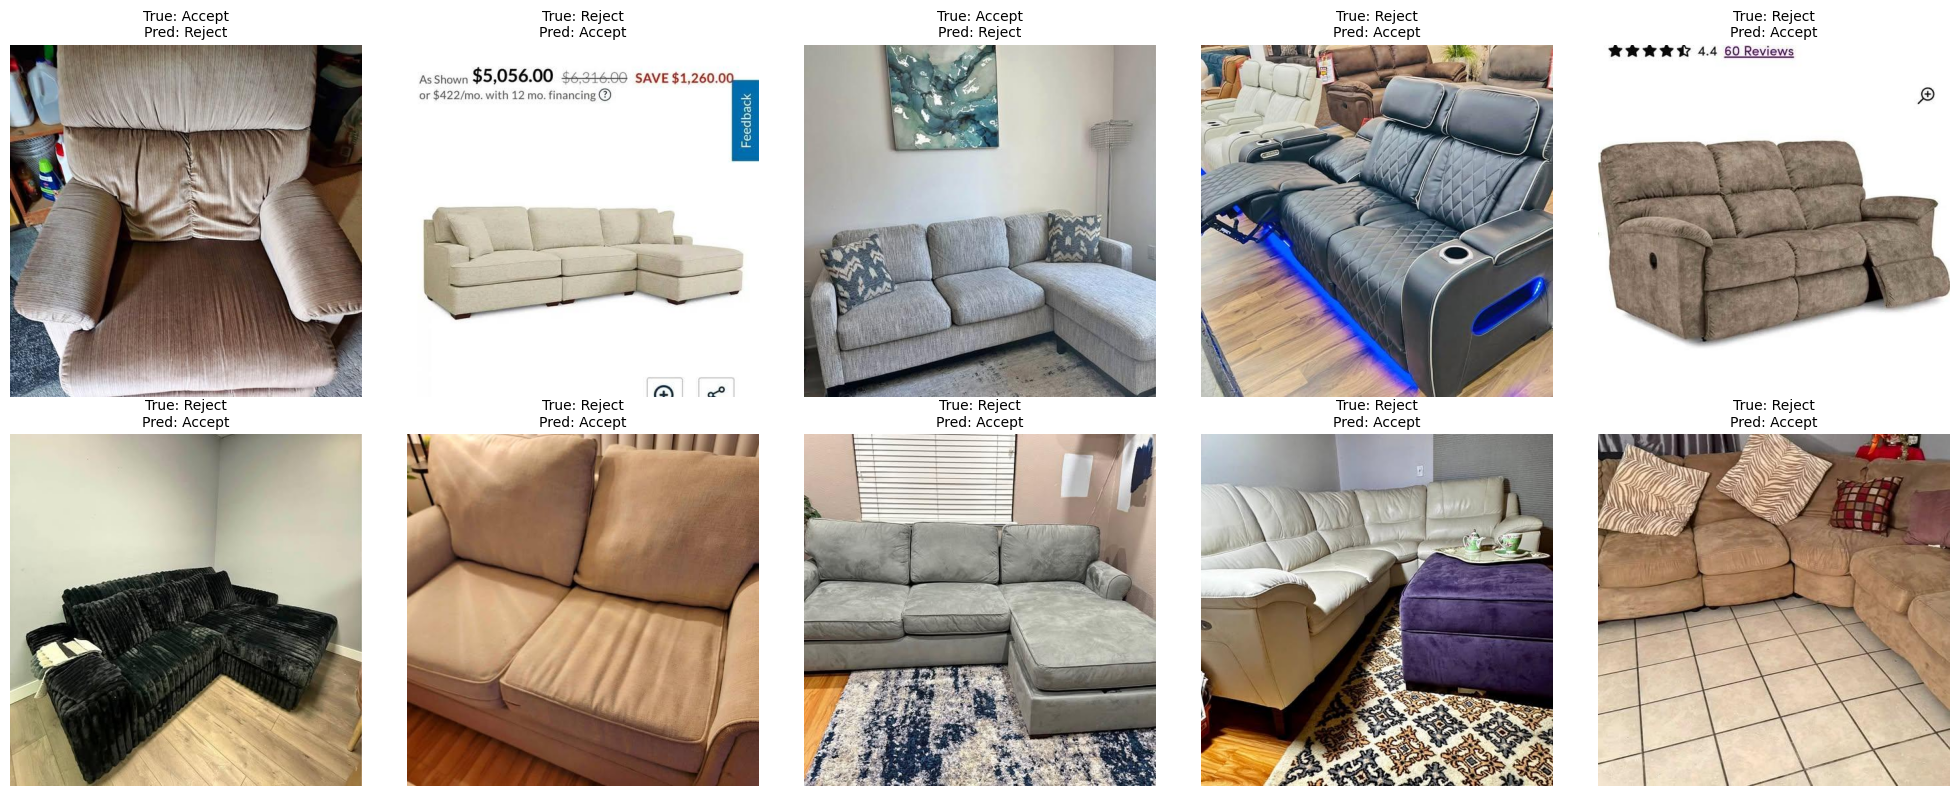

Results saved to results/vgg16/vgg16_high_quality_results.json

EXPERIMENT: VGG16 with BRAND_MSRP_ONLY data

Loading dataset from HuggingFace: adybacki/furniture-profitability-dataset
✓ Loaded 26,554 total samples

Filtering for data_mode: brand_msrp_only
✓ 5,209 samples after filtering

Original class distribution: {1: 3499, 0: 1710}
Balancing classes to 1710 samples each...
Balanced class distribution: {1: 1710, 0: 1710}

Train samples: 2736
Validation samples: 342
Test samples: 342
Dataset initialized with 2736 samples
Class distribution: {0: 1368, 1: 1368}
Dataset initialized with 342 samples
Class distribution: {0: 171, 1: 171}
Dataset initialized with 342 samples
Class distribution: {1: 171, 0: 171}

Training vgg16_brand_msrp_only



────────────────────────────────────────────────────────────
✓ EPOCH 1/15 COMPLETE - Time: 20.39s
────────────────────────────────────────────────────────────
Train - Loss: 0.7250 | Acc: 0.5683 | F1: 0.5710
Val   - Loss: 0.6274 | Acc: 0.6520 | F1: 0.6827
🏆 New best model saved (F1: 0.6827)
────────────────────────────────────────────────────────────



────────────────────────────────────────────────────────────
✓ EPOCH 2/15 COMPLETE - Time: 20.34s
────────────────────────────────────────────────────────────
Train - Loss: 0.6548 | Acc: 0.6334 | F1: 0.6388
Val   - Loss: 0.6515 | Acc: 0.6345 | F1: 0.6377
────────────────────────────────────────────────────────────



────────────────────────────────────────────────────────────
✓ EPOCH 3/15 COMPLETE - Time: 20.35s
────────────────────────────────────────────────────────────
Train - Loss: 0.6080 | Acc: 0.6743 | F1: 0.6814
Val   - Loss: 0.6918 | Acc: 0.5760 | F1: 0.3439
────────────────────────────────────────────────────────────



────────────────────────────────────────────────────────────
✓ EPOCH 4/15 COMPLETE - Time: 20.23s
────────────────────────────────────────────────────────────
Train - Loss: 0.5503 | Acc: 0.7124 | F1: 0.7168
Val   - Loss: 0.6261 | Acc: 0.6842 | F1: 0.6667
────────────────────────────────────────────────────────────



────────────────────────────────────────────────────────────
✓ EPOCH 5/15 COMPLETE - Time: 20.18s
────────────────────────────────────────────────────────────
Train - Loss: 0.5177 | Acc: 0.7427 | F1: 0.7449
Val   - Loss: 0.6414 | Acc: 0.6784 | F1: 0.7011
🏆 New best model saved (F1: 0.7011)
────────────────────────────────────────────────────────────



────────────────────────────────────────────────────────────
✓ EPOCH 6/15 COMPLETE - Time: 20.24s
────────────────────────────────────────────────────────────
Train - Loss: 0.4682 | Acc: 0.7727 | F1: 0.7746
Val   - Loss: 0.6872 | Acc: 0.6696 | F1: 0.6523
────────────────────────────────────────────────────────────



────────────────────────────────────────────────────────────
✓ EPOCH 7/15 COMPLETE - Time: 20.24s
────────────────────────────────────────────────────────────
Train - Loss: 0.4084 | Acc: 0.8114 | F1: 0.8143
Val   - Loss: 0.7085 | Acc: 0.6696 | F1: 0.6852
────────────────────────────────────────────────────────────



────────────────────────────────────────────────────────────
✓ EPOCH 8/15 COMPLETE - Time: 20.33s
────────────────────────────────────────────────────────────
Train - Loss: 0.4188 | Acc: 0.7979 | F1: 0.7994
Val   - Loss: 0.7457 | Acc: 0.6550 | F1: 0.6722
────────────────────────────────────────────────────────────



────────────────────────────────────────────────────────────
✓ EPOCH 9/15 COMPLETE - Time: 20.29s
────────────────────────────────────────────────────────────
Train - Loss: 0.3295 | Acc: 0.8571 | F1: 0.8589
Val   - Loss: 0.8660 | Acc: 0.6667 | F1: 0.6935
────────────────────────────────────────────────────────────



────────────────────────────────────────────────────────────
✓ EPOCH 10/15 COMPLETE - Time: 20.20s
────────────────────────────────────────────────────────────
Train - Loss: 0.3153 | Acc: 0.8688 | F1: 0.8689
Val   - Loss: 0.9133 | Acc: 0.6140 | F1: 0.6700
────────────────────────────────────────────────────────────



────────────────────────────────────────────────────────────
✓ EPOCH 11/15 COMPLETE - Time: 20.05s
────────────────────────────────────────────────────────────
Train - Loss: 0.2803 | Acc: 0.8805 | F1: 0.8818
Val   - Loss: 0.9100 | Acc: 0.6550 | F1: 0.6609
────────────────────────────────────────────────────────────



────────────────────────────────────────────────────────────
✓ EPOCH 12/15 COMPLETE - Time: 20.18s
────────────────────────────────────────────────────────────
Train - Loss: 0.2468 | Acc: 0.9013 | F1: 0.9017
Val   - Loss: 0.9162 | Acc: 0.6579 | F1: 0.6528
────────────────────────────────────────────────────────────



────────────────────────────────────────────────────────────
✓ EPOCH 13/15 COMPLETE - Time: 20.13s
────────────────────────────────────────────────────────────
Train - Loss: 0.2497 | Acc: 0.9006 | F1: 0.9013
Val   - Loss: 0.9821 | Acc: 0.6404 | F1: 0.6168
────────────────────────────────────────────────────────────



────────────────────────────────────────────────────────────
✓ EPOCH 14/15 COMPLETE - Time: 20.23s
────────────────────────────────────────────────────────────
Train - Loss: 0.1971 | Acc: 0.9207 | F1: 0.9209
Val   - Loss: 1.0299 | Acc: 0.6374 | F1: 0.6353
────────────────────────────────────────────────────────────



────────────────────────────────────────────────────────────
✓ EPOCH 15/15 COMPLETE - Time: 20.30s
────────────────────────────────────────────────────────────
Train - Loss: 0.1887 | Acc: 0.9269 | F1: 0.9271
Val   - Loss: 1.0936 | Acc: 0.6316 | F1: 0.6182
────────────────────────────────────────────────────────────

✓ TRAINING COMPLETE - vgg16_brand_msrp_only
Best Validation F1: 0.7011
Total Epochs: 15


EXPERIMENT SUMMARY
Model: VGG16
Data Mode: brand_msrp_only

Test Set Performance:
  Accuracy:  0.6433
  F1 Score:  0.6514
  Precision: 0.6369
  Recall:    0.6667



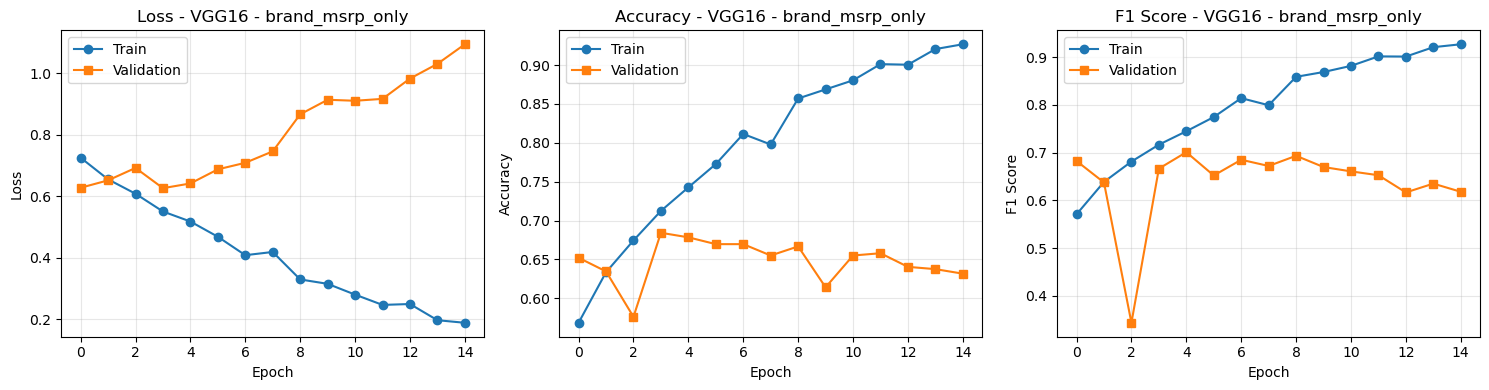

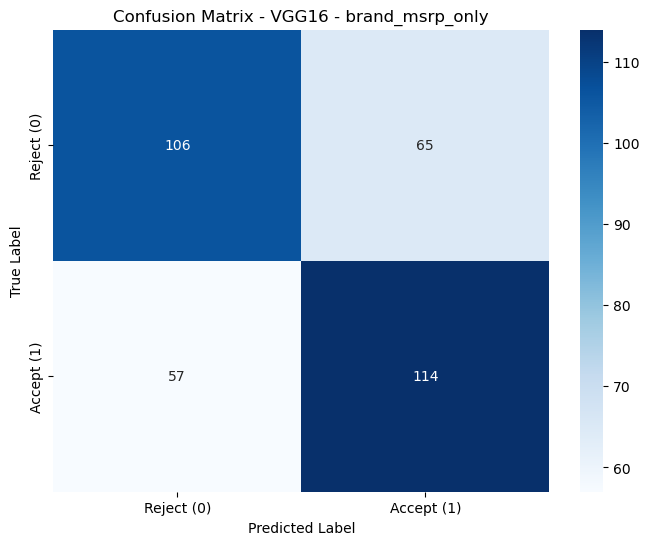


Analyzing misclassified examples...


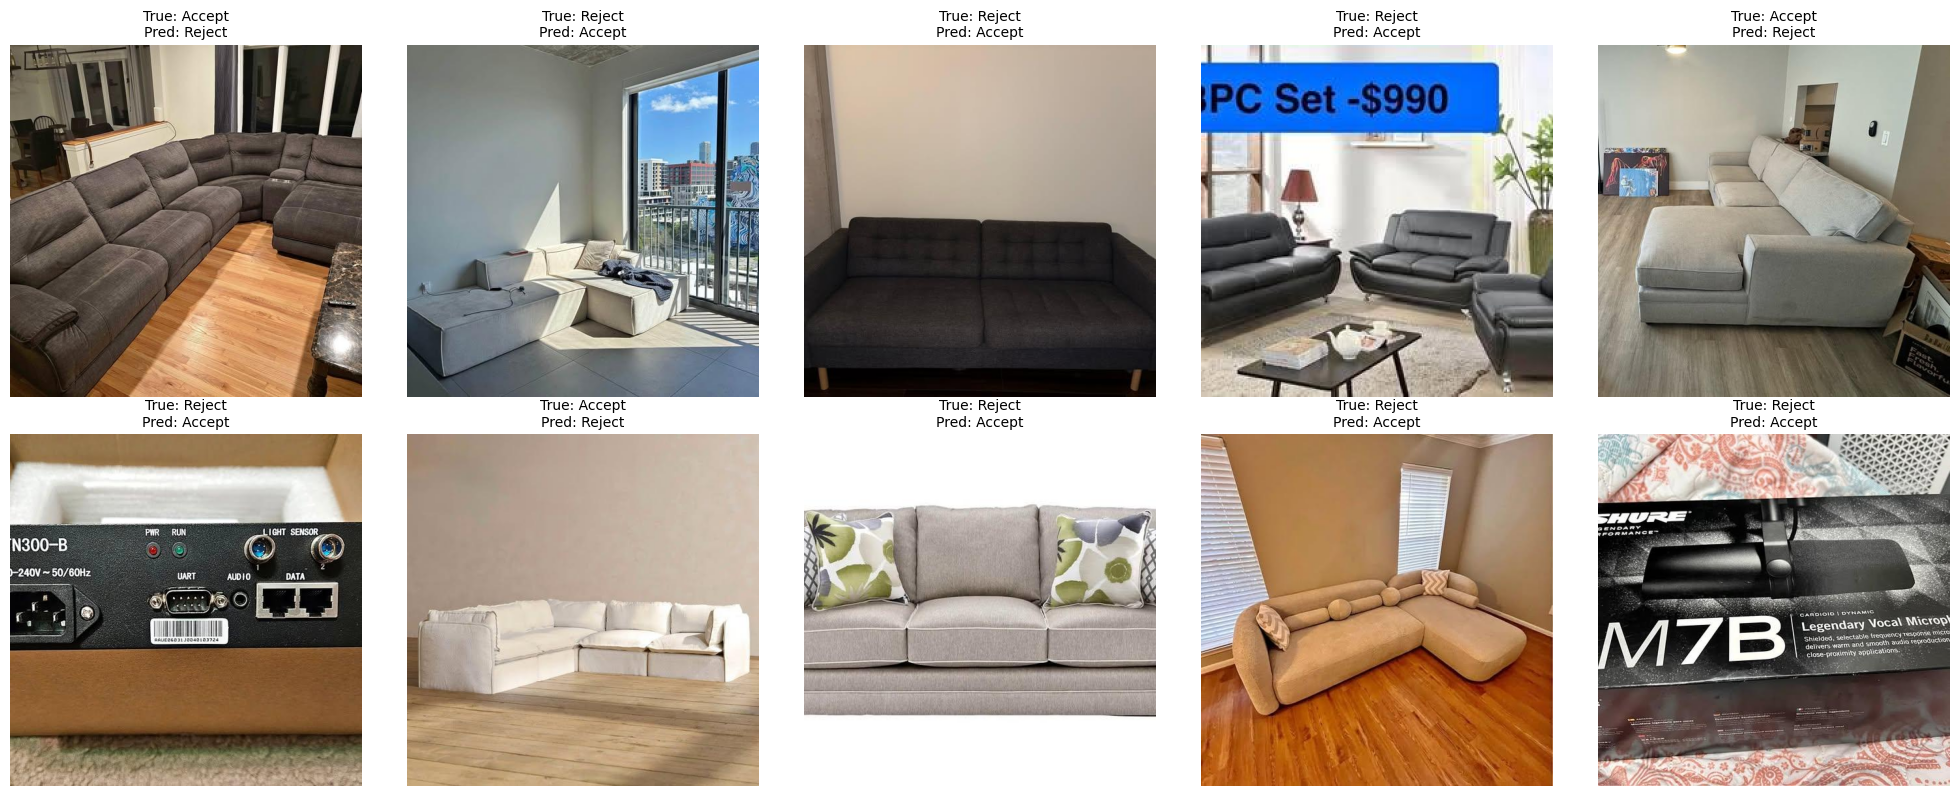

Results saved to results/vgg16/vgg16_brand_msrp_only_results.json


KeyboardInterrupt: 

In [ ]:
all_results = {}

for data_mode in DATA_MODES:
    print(f"\n{'='*80}")
    print(f"EXPERIMENT: VGG16 with {data_mode.upper()} data")
    print(f"{'='*80}\n")
    
    # Load and split data from HuggingFace
    train_idx, val_idx, test_idx, hf_dataset = load_and_split_hf_data(
        DATASET_REPO,
        data_mode=data_mode,
        test_size=0.2,
        random_state=42
    )
    
    # Create data loaders
    train_loader, val_loader, test_loader, train_dataset, val_dataset, test_dataset = get_hf_data_loaders(
        train_idx, val_idx, test_idx, hf_dataset,
        transform, transform,
        batch_size=BATCH_SIZE
    )
    
    # Create model
    model = create_vgg16_model()
    model = model.to(DEVICE)
    
    # Loss and optimizer
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.classifier.parameters(), lr=LEARNING_RATE)
    
    # Train model
    model_name = f"vgg16_{data_mode}"
    history = train_model(
        model, train_loader, val_loader, criterion, optimizer,
        DEVICE, NUM_EPOCHS, model_name, save_dir=MODELS_DIR
    )
    
    # Load best model for evaluation
    model.load_state_dict(torch.load(MODELS_DIR / f"{model_name}_best.pth"))
    
    # Evaluate on test set
    test_results = evaluate_model(model, test_loader, criterion, DEVICE)
    
    # Store results
    all_results[data_mode] = {
        'model_name': 'VGG16',
        'data_mode': data_mode,
        'num_epochs': NUM_EPOCHS,
        'batch_size': BATCH_SIZE,
        'learning_rate': LEARNING_RATE,
        'train_samples': len(train_dataset),
        'val_samples': len(val_dataset),
        'test_samples': len(test_dataset),
        'test_accuracy': test_results['accuracy'],
        'test_f1': test_results['f1'],
        'test_precision': test_results['precision'],
        'test_recall': test_results['recall'],
        'history': history
    }
    
    # Print summary
    print_experiment_summary(all_results[data_mode])
    
    # Plot training history
    plot_training_history(
        history, 
        f"VGG16 - {data_mode}",
        save_path=RESULTS_DIR / f"training_history_{data_mode}.png"
    )
    
    # Plot confusion matrix
    plot_confusion_matrix(
        test_results['labels'],
        test_results['predictions'],
        f"VGG16 - {data_mode}",
        save_path=RESULTS_DIR / f"confusion_matrix_{data_mode}.png"
    )
    
    # Visualize misclassified examples
    print("\nAnalyzing misclassified examples...")
    visualize_misclassified(
        model, test_dataset, DEVICE, 
        num_examples=10,
        save_path=RESULTS_DIR / f"misclassified_{data_mode}.png"
    )
    
    # Save results
    save_experiment_results(
        all_results[data_mode],
        f"vgg16_{data_mode}",
        save_dir=RESULTS_DIR
    )

## Compare Results Across Data Modes


VGG16 RESULTS COMPARISON
      Data Mode  Train Size  Test Accuracy  Test F1  Test Precision  Test Recall
            All       13561       0.589033 0.629452        0.573088     0.698113
   High Quality       10276       0.614008 0.646724        0.595020     0.708268
Brand Msrp Only        2736       0.643275 0.651429        0.636872     0.666667



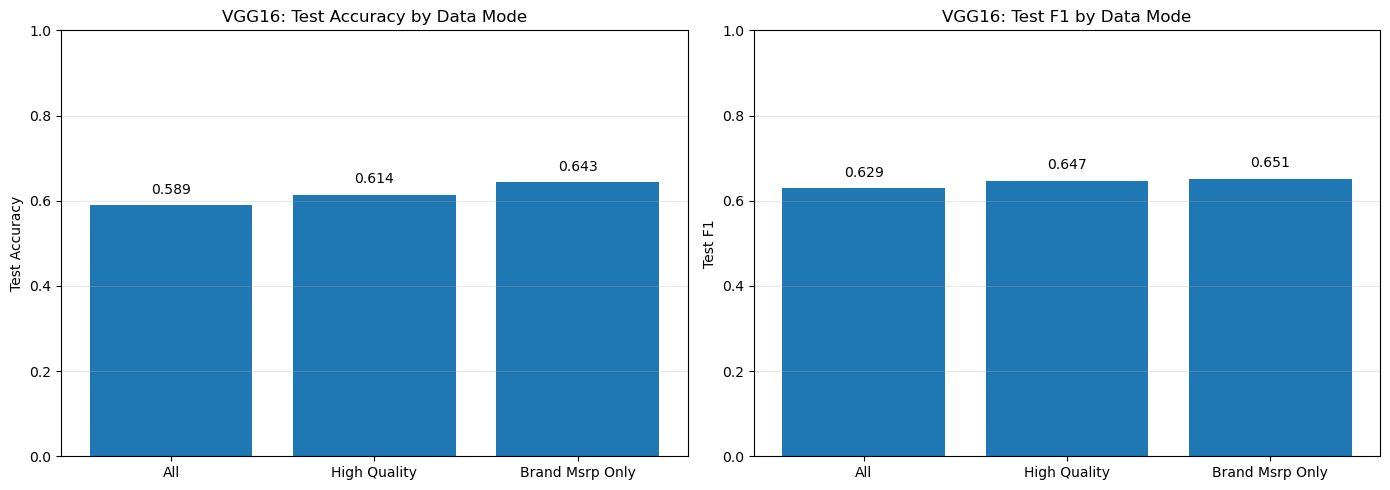

In [9]:
import matplotlib.pyplot as plt

# Create comparison dataframe
comparison_df = pd.DataFrame([
    {
        'Data Mode': mode.replace('_', ' ').title(),
        'Train Size': results['train_samples'],
        'Test Accuracy': results['test_accuracy'],
        'Test F1': results['test_f1'],
        'Test Precision': results['test_precision'],
        'Test Recall': results['test_recall']
    }
    for mode, results in all_results.items()
])

print("\n" + "="*80)
print("VGG16 RESULTS COMPARISON")
print("="*80)
print(comparison_df.to_string(index=False))
print("="*80 + "\n")

# Plot comparison
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

metrics = ['Test Accuracy', 'Test F1']
for ax, metric in zip(axes, metrics):
    ax.bar(comparison_df['Data Mode'], comparison_df[metric])
    ax.set_ylabel(metric)
    ax.set_title(f'VGG16: {metric} by Data Mode')
    ax.set_ylim([0, 1])
    ax.grid(True, alpha=0.3, axis='y')
    
    # Add value labels on bars
    for i, v in enumerate(comparison_df[metric]):
        ax.text(i, v + 0.02, f'{v:.3f}', ha='center', va='bottom')

plt.tight_layout()
plt.savefig(RESULTS_DIR / 'vgg16_comparison.png', dpi=300, bbox_inches='tight')
plt.show()